## DQC layer 

### **Kaggle task data holder:**

https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales

### **Description:**

- Your current goal is get familiar with the data you were given, so in this task you should create a notebook that would show all data you have
- The second task is Data Quality Check layer. Since you would work a lot with your data, it would be useful to create a dqc notebook that would be used to mark all possible issues that your data have:
    - Outliers
    - Poor dynamic all a lot of missing information
    - Data inconsistency
- Note: the main question you should answer in order to understand DQC layer is where is it used, so we use DQC in order to create ETL layer or conduct a data extraction

### **Possible Tools:**

- Data visualisation - seaborn, plotly, matplotlib
- Data processing - pandas, numpy, statsmodels, scikit-learn

## In this notebook I only check for various possible data issues. All the needed data transformations are performed within the ETL layer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys

sys.path.append("../")
from scripts.dqc import DataQualityCheck  # dqc.py module

In [2]:
# !kaggle competitions download -c competitive-data-science-predict-future-sales

In [3]:
# !unzip competitive-data-science-predict-future-sales.zip -d ../data

### **File descriptions**

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

### **Data fields**

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

## 1. Load data into dataframes and show data structure

In [2]:
train_df = pd.read_csv("../data/sales_train.csv")
test_df = pd.read_csv("../data/test.csv")
items_df = pd.read_csv("../data/items.csv")
categories_df = pd.read_csv("../data/item_categories.csv")
shops_df = pd.read_csv("../data/shops.csv")

In [3]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


### Look at **train_df**

In [4]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
print(train_df.info(), "\n\n")

pd.set_option("display.float_format", lambda x: "%.2f" % x)
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None 


       date_block_num    shop_id    item_id  item_price  item_cnt_day
count      2935849.00 2935849.00 2935849.00  2935849.00    2935849.00
mean            14.57      33.00   10197.23      890.85          1.24
std              9.42      16.23    6324.30     1729.80          2.62
min              0.00       0.00       0.00       -1.00        -22.00
25%              7.00      22.00    4476.00      249.00          1.00
50%             14.00      31.00    9343.00      399.00          1.00
75%             23.00      47.00   15684.00      999.00          1.00
max             33.00   

In [6]:
DataQualityCheck.check_if_integers(train_df, "item_cnt_day")

all item_cnt_day values are actually integers


1)All numeric columns' values are less than **10^6** and 2) **item_cnt_day** feature is intended to be integer,
 
so we should transform dtypes in ETL

### Look at **test_df**

In [7]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [8]:
print(test_df.info(), "\n\n")
print(test_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None 


             ID   shop_id   item_id
count 214200.00 214200.00 214200.00
mean  107099.50     31.64  11019.40
std    61834.36     17.56   6252.64
min        0.00      2.00     30.00
25%    53549.75     16.00   5381.50
50%   107099.50     34.50  11203.00
75%   160649.25     47.00  16071.50
max   214199.00     59.00  22167.00


### Look at **items_df**

In [9]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
print(items_df.info(), "\n\n")
print(items_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None 


       item_id  item_category_id
count 22170.00          22170.00
mean  11084.50             46.29
std    6400.07             15.94
min       0.00              0.00
25%    5542.25             37.00
50%   11084.50             40.00
75%   16626.75             58.00
max   22169.00             83.00


### Look at **categories_df**

In [11]:
categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [12]:
print(categories_df.info(), "\n\n")
print(categories_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None 


       item_category_id
count             84.00
mean              41.50
std               24.39
min                0.00
25%               20.75
50%               41.50
75%               62.25
max               83.00


### Look at **shops_df**

In [13]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [14]:
print(shops_df.info(), "\n\n")
print(shops_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None 


       shop_id
count    60.00
mean     29.50
std      17.46
min       0.00
25%      14.75
50%      29.50
75%      44.25
max      59.00


### **test_df, items_df, categories_df, shops_df** sets are all fine

## 2. Check missing values

In [15]:
dataframes = [train_df, test_df, items_df, categories_df, shops_df]

for df in dataframes:
    DataQualityCheck.check_missing_data(df)

No missing data found
No missing data found
No missing data found
No missing data found
No missing data found


## 3. Search for duplicates

In [16]:
for df in dataframes:
    DataQualityCheck.check_duplicates(df)

Number of duplicated rows: 12
Number of duplicated rows: 0
Number of duplicated rows: 0
Number of duplicated rows: 0
Number of duplicated rows: 0


In [17]:
train_df[train_df.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,05.01.2013,0,54,20130,149.00,1.00
76962,05.01.2013,0,54,20130,149.00,1.00
1435365,23.02.2014,13,50,3423,999.00,1.00
1435367,23.02.2014,13,50,3423,999.00,1.00
1496765,23.03.2014,14,21,3423,999.00,1.00
1496766,23.03.2014,14,21,3423,999.00,1.00
1671872,01.05.2014,16,50,3423,999.00,1.00
1671873,01.05.2014,16,50,3423,999.00,1.00
1866322,12.07.2014,18,25,3423,999.00,1.00
1866340,12.07.2014,18,25,3423,999.00,1.00


There all cases of item selling are not aggregated by "date, shop_id, item_id", which means that the same item could be fairly sold multiple times within one day ond one shop. That's why these "duplicates" are actually not duplicates, so they will later be aggregated by monthly sales too.

## 4. Check data inconsistency
Search for possible negative values

In [18]:
DataQualityCheck.check_negative_values(train_df, "item_cnt_day")

0.2505578454477734 percent of values are negative


This result may possibly mean that sales_train.csv file also contains data about items returned to shops. In this case these rows affect total monthly sales value, so it's better to leave them in the dataset.

In [19]:
DataQualityCheck.check_negative_values(train_df, "item_price", return_negatives=True)

3.406169731481422e-05 percent of values are negative


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.00,1.00


This row should be just a mistake in the process of collecting/entering data, so can be fairly deleted.

## Let's see how do shop names look like

In [20]:
shops_df["shop_name"].unique().tolist()[:10]

['!Якутск Орджоникидзе, 56 фран',
 '!Якутск ТЦ "Центральный" фран',
 'Адыгея ТЦ "Мега"',
 'Балашиха ТРК "Октябрь-Киномир"',
 'Волжский ТЦ "Волга Молл"',
 'Вологда ТРЦ "Мармелад"',
 'Воронеж (Плехановская, 13)',
 'Воронеж ТРЦ "Максимир"',
 'Воронеж ТРЦ Сити-Парк "Град"',
 'Выездная Торговля']

Print all unique shop cities

In [21]:
shops_df["shop_city"] = shops_df["shop_name"].apply(lambda x: x.split(" ")[0])
print("Number of unique shop cities:", len(shops_df["shop_city"].unique()))
shops_df["shop_city"].unique()

Number of unique shop cities: 32


array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [22]:
print(shops_df[shops_df["shop_city"] == "!Якутск"]["shop_name"].unique())
print(shops_df[shops_df["shop_city"] == "Якутск"]["shop_name"].unique())

['!Якутск Орджоникидзе, 56 фран' '!Якутск ТЦ "Центральный" фран']
['Якутск Орджоникидзе, 56' 'Якутск ТЦ "Центральный"']


'!Якутск' and 'Якутск' cities seam to have the same shops, so they should be united

Find corresponding shop ids

In [23]:
print("Орджоникидзе")
print(
    shops_df[shops_df["shop_name"] == "!Якутск Орджоникидзе, 56 фран"][
        "shop_id"
    ].unique()
)
print(shops_df[shops_df["shop_name"] == "Якутск Орджоникидзе, 56"]["shop_id"].unique())
print("Центральный")
print(
    shops_df[shops_df["shop_name"] == '!Якутск ТЦ "Центральный" фран'][
        "shop_id"
    ].unique()
)
print(shops_df[shops_df["shop_name"] == 'Якутск ТЦ "Центральный"']["shop_id"].unique())

Орджоникидзе
[0]
[57]
Центральный
[1]
[58]


In [24]:
shops_df[shops_df["shop_city"] == "Жуковский"]["shop_name"].unique()

array(['Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²'],
      dtype=object)

In [25]:
print(
    shops_df[shops_df["shop_name"] == "Жуковский ул. Чкалова 39м?"]["shop_id"].unique()
)
print(
    shops_df[shops_df["shop_name"] == "Жуковский ул. Чкалова 39м²"]["shop_id"].unique()
)

[10]
[11]


The same issue for 'Жуковский ул. Чкалова 39м?' and 'Жуковский ул. Чкалова 39м²'

I will transform all these features later in the ETL Layer

## Do the same analysis for the **item_name** feature

In [26]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [27]:
items_df["item_name"].duplicated().sum()

0

### As we can see, item_names have lots of unusual symbols - some of them are perhaps informative, while others might be just mistakes. Let's try to clean them

In [28]:
import re


def clean_item_name(name):
    name = re.sub(r"[^\w\s]", "", name)
    name = re.sub(r" D$", "", name)
    return name.lower()


items_df["clean_item_name"] = items_df["item_name"].apply(clean_item_name)

In [29]:
items_df.head()

,item_name,item_id,item_category_id,clean_item_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,во власти наваждения пласт
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,abbyy finereader 12 professional edition full ...
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,в лучах славы unv
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,голубая волна univ
4,***КОРОБКА (СТЕКЛО) D,4,40,коробка стекло


Now we have just letters and digits left, so it's time to search for duplicates

In [30]:
print(items_df["clean_item_name"].duplicated().sum())

items_df[items_df["clean_item_name"].duplicated(keep=False)][:20]

71


,item_name,item_id,item_category_id,clean_item_name
12,*МИХЕЙ И ДЖУМАНДЖИ Сука любовь,12,55,михей и джуманджи сука любовь
2268,"Call of Duty. Ghosts [PS4, русская версия]",2268,20,call of duty ghosts ps4 русская версия
2331,"Call of Duty: Ghosts [PS4, русская версия]",2331,20,call of duty ghosts ps4 русская версия
8247,АЛЫЕ ПАРУСА (Регион),8247,40,алые паруса регион
8248,АЛЫЕ ПАРУСА (регион),8248,40,алые паруса регион
8289,АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (Регион),8289,40,английский вместе с хрюшей и ч 1 регион
8290,АНГЛИЙСКИЙ ВМЕСТЕ С ХРЮШЕЙ И… ч. 1 (регион),8290,40,английский вместе с хрюшей и ч 1 регион
8298,АНДРЕЙ РУБЛЕВ (Регион),8298,40,андрей рублев регион
8299,АНДРЕЙ РУБЛЕВ (регион),8299,40,андрей рублев регион
8422,АФОНЯ (Регион),8422,40,афоня регион


There is 71 set of duplicate item_names, most of them come in pairs *(item_id, item_if + 1)* and vary in upper-/lowercase symbols. I'll check whether there are differences in corresponding shops and prices of that items after merging the datasets: if they are more or less similar, I will drop the duplicates in ETL.

## 5. Check ids' and names' uniqueness for supplementary sets

In [31]:
DataQualityCheck.check_unique_ids(
    categories_df, "item_category_name", "item_category_id"
)

All names and ids are unique


In [32]:
DataQualityCheck.check_unique_ids(shops_df, "shop_name", "shop_id")

All names and ids are unique


In [33]:
DataQualityCheck.check_unique_ids(items_df, "item_name", "item_id")

All names and ids are unique


## 6. Search for outliers in **train_df**

### Analyze **'item_price'** feature

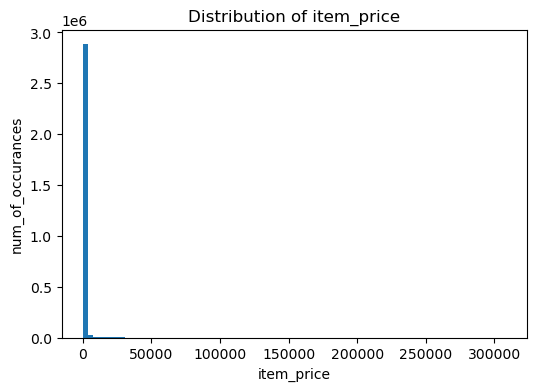

In [34]:
plt.figure(figsize=(6, 4))
plt.hist(train_df["item_price"], bins=80)
plt.xlabel("item_price")
plt.ylabel("num_of_occurances")
plt.title("Distribution of item_price")
plt.show()

It's better to perform log() transformation on 'item_price' feature to reduce skewness.

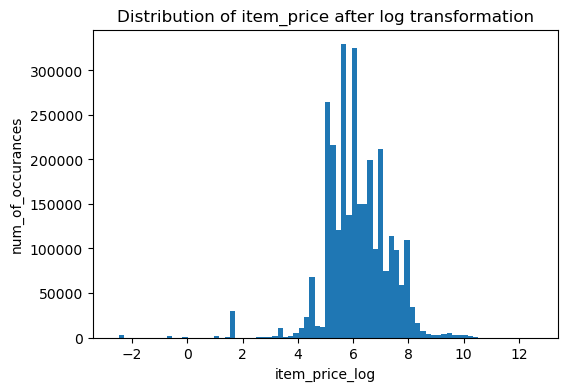

In [37]:
train_df["item_price_log"] = np.log(train_df["item_price"])

plt.figure(figsize=(6, 4))
plt.hist(train_df["item_price_log"], bins=80)
plt.xlabel("item_price_log")
plt.ylabel("num_of_occurances")
plt.title("Distribution of item_price after log transformation")
plt.show()

In [38]:
DataQualityCheck.find_outliers(train_df, "item_price_log")

IQR: 1.3893018821838465
Number of outliers: 74775
Percent of outliers: 2.546963416715233
Upper bound value: 8.990707601924324, lower bound value: 3.4335000731889376
Min value: -2.659260036932778, Max value: 12.637790124782404


Speaking about **'item_price'** feature, in order to decide whether to delete outliers or not it's good to understand the reasons of their presence. It would be easier to merge all information into one dataframe, so outliers will be discussed later in EDA layer

### Analyze **'item_cnt_day'** feature

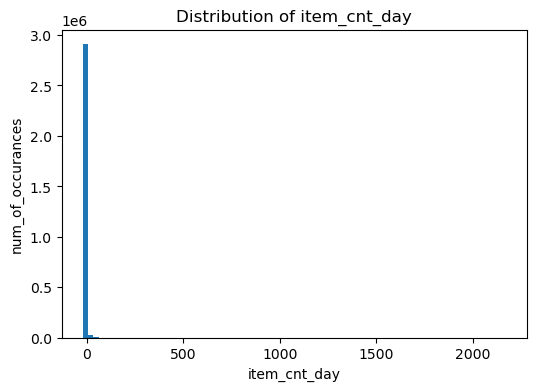

In [39]:
# plot histogram
plt.figure(figsize=(6, 4))
plt.hist(train_df["item_cnt_day"], bins=80)
plt.xlabel("item_cnt_day")
plt.ylabel("num_of_occurances")
plt.title("Distribution of item_cnt_day")
plt.show()

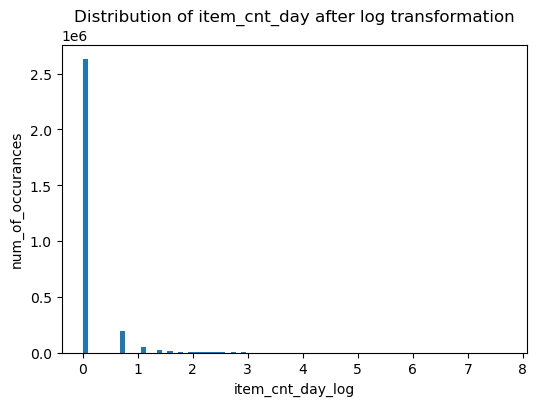

In [42]:
train_df["item_cnt_day_log"] = np.log(train_df["item_cnt_day"])
plt.figure(figsize=(6, 4))
plt.hist(train_df["item_cnt_day_log"], bins=80)
plt.xlabel("item_cnt_day_log")
plt.ylabel("num_of_occurances")
plt.title("Distribution of item_cnt_day after log transformation")
plt.show()

In [43]:
print("'item_count_day' max value:", train_df["item_cnt_day"].max())
print(
    len(train_df[train_df["item_cnt_day"] >= 10]) / len(train_df) * 100,
    "% of rows have 'item_count_day' >= 10",
)

'item_count_day' max value: 2169.0
0.4065604191496225 % of rows have 'item_count_day' >= 10


As the visualization shows, 'item_cnt_day' feature is extremely right-skewed, so that even **log** transformation doesn't make it look just a little closer to normal distribution. That's why usual techniques for finding outliers are hardly helpful. I'll leave it for the EDA or even for training models' experiments.

## 7. Check the mismatch between item_ids and shop_ids across files

### Check across test and train datasets

In [44]:
# for item_id feature
test_set = set(test_df["item_id"].unique().tolist())
train_set = set(train_df["item_id"].unique().tolist())

len(test_set - train_set)

363

In [45]:
# for shop_id feature
test_shop_set = set(test_df["shop_id"].unique().tolist())
train_shop_set = set(train_df["shop_id"].unique().tolist())

len(test_shop_set - train_shop_set)

0

There are 363 item_ids that are not present in the train dataset. This means, when predicting for test, there will be missing values in the features based on **item_price** and **item_cnt_day** columns.
Maybe these items are added to test to predict for company, whether to add them to the list of goods in the future or not

### Check across train_df, test_df and items_df

In [46]:
# for item_id feature
train_item_set = set(train_df["item_id"].unique().tolist())
item_set = set(items_df["item_id"].unique().tolist())

len(train_set - item_set)

0

In [47]:
# for item_id feature
test_item_set = set(test_df["item_id"].unique().tolist())
item_set = set(items_df["item_id"].unique().tolist())

len(test_set - item_set)

0

### Check across train_df, test_df and shops_df

In [48]:
# for shop_id feature
train_shop_set = set(train_df["shop_id"].unique().tolist())
shop_set = set(shops_df["shop_id"].unique().tolist())

len(train_shop_set - shop_set)

0

In [49]:
# for shop_id feature
test_shop_set = set(test_df["shop_id"].unique().tolist())
shop_set = set(shops_df["shop_id"].unique().tolist())

len(test_shop_set - shop_set)

0

### Check across items_df and categories_df

In [50]:
# for item_category_id feature
items_categories_set = set(items_df["item_category_id"].unique().tolist())
categories_set = set(categories_df["item_category_id"].unique().tolist())

len(items_categories_set - categories_set)

0

### Summing all up, the only mismatch between ids' sets is for "item_id" feature between test and train datasets 

## **Conclusion**

After data quality check process it's clear that some transformations should be done:

1. Change dtypes for some **train_df** columns
2. Delete some **train_df** rows with negative values
3. Fix inconsistent data in **shops.csv** and **items.csv**
3. Merge **train_df** with **items_df, categories_df, shops_df**. Do the same with **test_df**